In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

In [3]:
import math
import numpy as np
from jax import random
from jax import grad, jit, vmap

tau = 0.05  # seconds between state updates
kinematics_integrator = "euler"
gravity = 10.0
@jax.jit
def dynamics(state,action,params):
    """
    params[0,1,2]: pole mass, length, cart mass
    """
    x, x_dot, theta, theta_dot = state

    force = action 

    masscart,masspole,length = params
    total_mass = masspole + masscart
    polemass_length = masspole * length

    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)

    temp = (force + polemass_length * theta_dot ** 2 * sintheta) / total_mass
    thetaacc = (gravity * sintheta - costheta * temp) / (
        length * (4.0 / 3.0 - masspole * costheta ** 2 / total_mass)
    )
    xacc = temp - polemass_length * thetaacc * costheta / total_mass

    if kinematics_integrator == "euler":
        x = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc
    else:  # semi-implicit euler
        x_dot = x_dot + tau * xacc
        x = x + tau * x_dot
        theta_dot = theta_dot + tau * thetaacc
        theta = theta + tau * theta_dot

    return jnp.reshape(jnp.array([x, x_dot, theta, theta_dot]),(4,))

In [4]:
import math
import numpy as np
from jax import random
from jax import grad, jit, vmap

@jax.jit
def dynamics_PDP(state,action,params):
    g = 10.0
    dt = 0.05  # seconds between state updates
    kinematics_integrator = "euler"

    
    # get state and actions, which is different from gym env
    x, q, dx, dq = state
    U = action 
    mc,mp,l = params
    
    # computer the acceleration
    ddx = (U + mp * jnp.sin(q) * (l * dq * dq + g * jnp.cos(q))) / (
                mc + mp * jnp.sin(q) * jnp.sin(q))  # acceleration of x
    ddq = (-U * jnp.cos(q) - mp * l * dq * dq * jnp.sin(q) * jnp.cos(q) - (
                mc + mp) * g * jnp.sin(q)) / (
                      l * mc + l * mp * jnp.sin(q) * jnp.sin(q))  # acceleration of theta
    
    #computer current state
    if kinematics_integrator == "euler":
        x = x + dx * dt
        dx = dx + ddx * dt
        q = q + dq * dt
        dq = dq + ddq * dt
    else:
        dx = dx + ddx * dt
        x = x + dx * dt
        dq = dq + ddq * dt
        q = q + dq * dt
    return jnp.reshape(jnp.array([x, q, dx, dq]),(4,))

In [5]:
from jax.experimental import loops
from jax import ops
def loss_fn(params,states,actions,next_states):
    with loops.Scope() as s:
        s.loss = jnp.zeros((actions.shape[0],4))
        s.predicted_states = jnp.zeros((actions.shape[0],4))
        for i in s.range(s.predicted_states.shape[0]):
            s.predicted_states = ops.index_update(s.predicted_states, i,
                                                  dynamics_PDP(states[i],actions[i],params) )
        s.loss = s.predicted_states - next_states
        return jnp.mean(jnp.square(s.loss))  # mse
grad_loss = jax.jacfwd(loss_fn,argnums=0)

In [25]:
from jax.experimental import loops
from jax import ops
def loss_fn_traj(params,states,actions,next_states):
    with loops.Scope() as s:
        s.loss = jnp.zeros((actions.shape[0],4))
        s.predicted_states = jnp.zeros((actions.shape[0],4))
        s.predicted_states = ops.index_update(s.predicted_states, 0,
                                                  dynamics(states[0],actions[0],params) )
        for i in s.range(s.predicted_states.shape[0]-1):
            s.predicted_states = ops.index_update(s.predicted_states, i+1,
                                                  dynamics_PDP(s.predicted_states[i],actions[i+1],params) )
        s.loss = s.predicted_states - next_states
        return jnp.mean(jnp.square(s.loss))  # mse
grad_loss_traj = jax.jacfwd(loss_fn_traj,argnums=0)
hessian_loss_traj =  jax.jacfwd(grad_loss_traj,argnums=0)

In [7]:
import scipy.io as sio
load_data = sio.loadmat('/home/qinjielin/RL_Ws/Pontryagin-Differentiable-Programming/Examples/SysID/cartpole/data/cartpole_iodata.mat')
data = load_data['cartpole_iodata'][0, 0]

In [8]:
actions_data = data[0]
states_data = data[1]
true_params = data[2]
params = jnp.array([2.0,1.5,2.0])
loss_list = []
batch_size = 5
test_s,test_a,test_sdot = jnp.array(states_data[2][0:-1]),jnp.reshape(jnp.array(actions_data[2]),(20,)),jnp.array(states_data[2][1:])
for i in range(10):
#     traj_index = int(i/4)%2
#     batch_id = i%4
#     data_start,data_end  = (batch_id * 5), ((batch_id+1) *5 )
#     next_data_start,next_data_end  = data_start+1, data_end+1
#     states = jnp.array(states_data[traj_index][data_start:data_end])
#     actions =  jnp.reshape(jnp.array(actions_data[traj_index][data_start:data_end]),(batch_size,))
#     next_states = jnp.array(states_data[traj_index][next_data_start:next_data_end])
    traj_index = i%3
    states = jnp.array(states_data[traj_index][0:-1])
    actions =  jnp.reshape(jnp.array(actions_data[traj_index]),(states.shape[0],))
    next_states = jnp.array(states_data[traj_index][1:])
    
    grad = grad_loss(params,states,actions,next_states)
#     grad = grad_loss_traj(params,states,actions,next_states)
    loss = loss_fn(params,test_s,test_a,test_sdot)
#     loss = loss_fn_traj(params,test_s,test_a,test_sdot)
    params -= 0.1 * grad
    loss_list.append(loss)

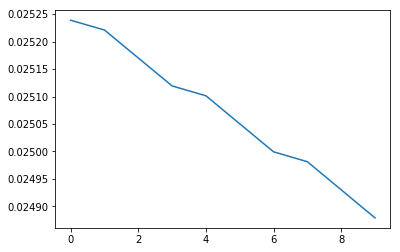

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

In [17]:
loss_list[0:]

[DeviceArray(0.02523875, dtype=float32),
 DeviceArray(0.02522095, dtype=float32),
 DeviceArray(0.02517007, dtype=float32),
 DeviceArray(0.02511922, dtype=float32),
 DeviceArray(0.02510133, dtype=float32),
 DeviceArray(0.02505033, dtype=float32),
 DeviceArray(0.02499935, dtype=float32),
 DeviceArray(0.02498138, dtype=float32),
 DeviceArray(0.02493025, dtype=float32),
 DeviceArray(0.02487914, dtype=float32)]

In [26]:
grad_loss_traj(jnp.array([1.0,1.0,1.0]),test_s,test_a,test_sdot)

DeviceArray([-0.23847377, -0.33954245,  1.6021191 ], dtype=float32)

In [22]:
loss_fn_traj(jnp.array([1.0,2.0,1.0]),test_s,test_a,test_sdot)

DeviceArray(0.4126432, dtype=float32)

In [360]:
from gym.envs.classic_control import rendering

In [378]:
class cartpole():
    def __init__(self):
        self.viewer = None
        return
    def render(self,params,state):
        masscart,masspole,length = params
        total_mass = masspole + masscart
        polemass_length = masspole * length

        x, x_dot, theta, theta_dot = state

        screen_width = 600
        screen_height = 400

        world_width = 2.4 * 2
        scale = screen_width / world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * polemass_length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(0.8, 0.6, 0.4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(0.5, 0.5, 0.8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array="human" == "rgb_array")

In [379]:
x = cartpole() 

In [391]:
x.render(params,states_data[0][0])

False

In [389]:
x.viewer=None

DeviceArray([0.09933709, 0.09958012, 0.10012527], dtype=float32)

DeviceArray([-0.17696618, -0.01834414,  0.4934444 ,  1.0533656 ], dtype=float32)

DeviceArray([[0.],
             [0.],
             [0.],
             [0.],
             [0.]], dtype=float32)